In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from cuml.ensemble import RandomForestRegressor as cuRF
import xgboost as xgb
from scripts.function_utils import past_timesteps, test_leave_house_out, total_averaged_metrics, add_energy_variation

#### Output file

In [2]:
sourceFile = open("../../gpu_logs/_loureiro_variation.txt", 'w')

### Load the data

In [3]:
merged = pd.read_csv("../../data/loureiro_meteo_selected.csv")
merged

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2022-05-12 12:00:00,Energy_1,20.6,20.90,20.30,359.0,359.0,6.30,10.40,0.00,...,0.041,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.039
1,2022-05-12 12:15:00,Energy_1,20.2,20.45,20.00,2.0,6.5,6.65,10.05,0.00,...,0.487,0.034,0.058,0.034,0.029,0.065,0.070,3,12,0.061
2,2022-05-12 12:30:00,Energy_1,20.1,20.30,19.90,360.0,1.0,6.40,9.80,0.00,...,0.340,0.037,0.038,0.055,0.047,0.030,0.122,3,12,0.038
3,2022-05-12 12:45:00,Energy_1,20.0,20.25,19.85,180.0,185.5,6.40,10.10,0.00,...,0.058,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.069
4,2022-05-12 13:00:00,Energy_1,20.2,20.40,19.90,1.0,10.0,5.90,9.40,0.00,...,0.044,0.024,0.026,0.036,0.020,0.329,0.125,3,13,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.4,16.50,16.30,340.0,338.0,2.50,3.40,0.00,...,0.015,0.041,0.032,0.009,0.010,0.010,0.023,2,1,0.009
1413236,2023-06-07 01:30:00,Energy_96,16.4,16.50,16.35,335.0,338.5,2.05,2.90,0.05,...,0.041,0.037,0.009,0.010,0.009,0.036,0.010,2,1,0.009
1413237,2023-06-07 01:45:00,Energy_96,16.5,16.50,16.40,333.0,313.0,1.80,2.70,0.10,...,0.038,0.016,0.010,0.009,0.020,0.039,0.009,2,1,0.040
1413238,2023-06-07 02:00:00,Energy_96,16.5,16.60,16.40,337.5,342.0,2.20,2.90,0.05,...,0.022,0.010,0.009,0.009,0.041,0.029,0.010,2,2,0.038


In [4]:
missing_values = merged.isna().sum()
selected_columns = merged.columns[np.where(missing_values <= 1000)]
df = merged[selected_columns]
print(df.isna().sum().sum())
df

0


,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2022-05-12 12:00:00,Energy_1,20.6,20.90,20.30,359.0,359.0,6.30,10.40,0.00,...,0.041,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.039
1,2022-05-12 12:15:00,Energy_1,20.2,20.45,20.00,2.0,6.5,6.65,10.05,0.00,...,0.487,0.034,0.058,0.034,0.029,0.065,0.070,3,12,0.061
2,2022-05-12 12:30:00,Energy_1,20.1,20.30,19.90,360.0,1.0,6.40,9.80,0.00,...,0.340,0.037,0.038,0.055,0.047,0.030,0.122,3,12,0.038
3,2022-05-12 12:45:00,Energy_1,20.0,20.25,19.85,180.0,185.5,6.40,10.10,0.00,...,0.058,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.069
4,2022-05-12 13:00:00,Energy_1,20.2,20.40,19.90,1.0,10.0,5.90,9.40,0.00,...,0.044,0.024,0.026,0.036,0.020,0.329,0.125,3,13,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.4,16.50,16.30,340.0,338.0,2.50,3.40,0.00,...,0.015,0.041,0.032,0.009,0.010,0.010,0.023,2,1,0.009
1413236,2023-06-07 01:30:00,Energy_96,16.4,16.50,16.35,335.0,338.5,2.05,2.90,0.05,...,0.041,0.037,0.009,0.010,0.009,0.036,0.010,2,1,0.009
1413237,2023-06-07 01:45:00,Energy_96,16.5,16.50,16.40,333.0,313.0,1.80,2.70,0.10,...,0.038,0.016,0.010,0.009,0.020,0.039,0.009,2,1,0.040
1413238,2023-06-07 02:00:00,Energy_96,16.5,16.60,16.40,337.5,342.0,2.20,2.90,0.05,...,0.022,0.010,0.009,0.009,0.041,0.029,0.010,2,2,0.038


In [ ]:
# zero_values = np.sum(df == 0)
# selected_columns = df.columns[np.where(zero_values < 5000)]
# df = df[selected_columns]
# print(np.where(np.sum(df == 0) > 1000)[0])
# df

### Interpolate missing values

In [ ]:
# df.index = pd.to_datetime(df["Time"])
# df.drop(["Time"], inplace=True, axis=1)
# for column in df.columns:
#     df[column] = df[column].interpolate(method='time', limit_direction="both")
# print(df.isna().sum().sum())
# df["Time"] = df.index
# df.reset_index(drop=True, inplace=True)
# column_names = df.columns.tolist()
# column_to_move = 'Time'
# column_names.remove(column_to_move)
# new_column_order = [column_to_move] + column_names
# df = df[new_column_order]
# df

In [ ]:
#df.to_csv("../../data/loureiro_40casas.csv", index=None)

In [ ]:
np.sum(df == 0)

## Save Dataframe with past timesteps

In [5]:
# df = pd.read_csv("../../data/loureiro_meteo.csv")
# df.Time = pd.to_datetime(df.Time)
# df

In [6]:
# number_of_timesteps = 97

In [7]:
# df_new = past_timesteps(df, number_of_timesteps)
# df_new

In [8]:
# df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
# df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
# df_new['Hour'] = df_new['Time'].dt.hour
# df_new

In [9]:
# df_new.to_csv("../../data/loureiro_meteo_oneweek.csv", index=False)

## Predict  5 folds with 10 random houses for test

In [10]:
# df = pd.read_csv("../../data/loureiro_meteo_oneweek.csv")
# df

In [11]:
# df_selected = df[["Time","Location","Temp_Med","Temp_Max","Temp_Min","Rumo_Vento_Med","Rumo_Vento_Max","Intensidade_Vento_Med","Intensidade_Vento_Max","Precip","Rad_Total","lag_1","lag_2","lag_3","lag_4","lag_96","lag_192","lag_288","lag_384","lag_480","lag_576","lag_672","DayOfWeek","Hour","Energy"]]
# df_selected

In [12]:
# df_selected.to_csv("../../data/loureiro_meteo_selected.csv", index=None)

In [13]:
df_test = pd.read_csv("../../data/loureiro_meteo_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("../../data/loureiro_meteo_selected.csv", engine='c', dtype=float32_cols)
df

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2022-05-12 12:00:00,Energy_1,20.600000,20.900000,20.299999,359.0,359.0,6.30,10.40,0.00,...,0.041,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.039
1,2022-05-12 12:15:00,Energy_1,20.200001,20.450001,20.000000,2.0,6.5,6.65,10.05,0.00,...,0.487,0.034,0.058,0.034,0.029,0.065,0.070,3,12,0.061
2,2022-05-12 12:30:00,Energy_1,20.100000,20.299999,19.900000,360.0,1.0,6.40,9.80,0.00,...,0.340,0.037,0.038,0.055,0.047,0.030,0.122,3,12,0.038
3,2022-05-12 12:45:00,Energy_1,20.000000,20.250000,19.850000,180.0,185.5,6.40,10.10,0.00,...,0.058,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.069
4,2022-05-12 13:00:00,Energy_1,20.200001,20.400000,19.900000,1.0,10.0,5.90,9.40,0.00,...,0.044,0.024,0.026,0.036,0.020,0.329,0.125,3,13,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.400000,16.500000,16.299999,340.0,338.0,2.50,3.40,0.00,...,0.015,0.041,0.032,0.009,0.010,0.010,0.023,2,1,0.009
1413236,2023-06-07 01:30:00,Energy_96,16.400000,16.500000,16.350000,335.0,338.5,2.05,2.90,0.05,...,0.041,0.037,0.009,0.010,0.009,0.036,0.010,2,1,0.009
1413237,2023-06-07 01:45:00,Energy_96,16.500000,16.500000,16.400000,333.0,313.0,1.80,2.70,0.10,...,0.038,0.016,0.010,0.009,0.020,0.039,0.009,2,1,0.040
1413238,2023-06-07 02:00:00,Energy_96,16.500000,16.600000,16.400000,337.5,342.0,2.20,2.90,0.05,...,0.022,0.010,0.009,0.009,0.041,0.029,0.010,2,2,0.038


## Add Variation as a feature

In [14]:
df = add_energy_variation(df)
df

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Variation,Energy
0,2022-05-12 12:00:00,Energy_1,20.600000,20.900000,20.299999,359.0,359.0,6.30,10.40,0.00,...,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.000000,0.039
1,2022-05-12 12:15:00,Energy_1,20.200001,20.450001,20.000000,2.0,6.5,6.65,10.05,0.00,...,0.034,0.058,0.034,0.029,0.065,0.070,3,12,0.563702,0.061
2,2022-05-12 12:30:00,Energy_1,20.100000,20.299999,19.900000,360.0,1.0,6.40,9.80,0.00,...,0.037,0.038,0.055,0.047,0.030,0.122,3,12,-0.377151,0.038
3,2022-05-12 12:45:00,Energy_1,20.000000,20.250000,19.850000,180.0,185.5,6.40,10.10,0.00,...,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.815312,0.069
4,2022-05-12 13:00:00,Energy_1,20.200001,20.400000,19.900000,1.0,10.0,5.90,9.40,0.00,...,0.024,0.026,0.036,0.020,0.329,0.125,3,13,-0.087089,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.400000,16.500000,16.299999,340.0,338.0,2.50,3.40,0.00,...,0.041,0.032,0.009,0.010,0.010,0.023,2,1,-0.100899,0.009
1413236,2023-06-07 01:30:00,Energy_96,16.400000,16.500000,16.350000,335.0,338.5,2.05,2.90,0.05,...,0.037,0.009,0.010,0.009,0.036,0.010,2,1,-0.001110,0.009
1413237,2023-06-07 01:45:00,Energy_96,16.500000,16.500000,16.400000,333.0,313.0,1.80,2.70,0.10,...,0.016,0.010,0.009,0.020,0.039,0.009,2,1,3.439512,0.040
1413238,2023-06-07 02:00:00,Energy_96,16.500000,16.600000,16.400000,337.5,342.0,2.20,2.90,0.05,...,0.010,0.009,0.009,0.041,0.029,0.010,2,2,-0.050237,0.038


In [15]:
num_houses_test = 8
locations = []
for i in range(10):
    np.random.seed(i*5)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['Energy_161', 'Energy_16', 'Energy_2', 'Energy_118', 'Energy_132',
        'Energy_146', 'Energy_48', 'Energy_135'], dtype=object),
 array(['Energy_16', 'Energy_161', 'Energy_17', 'Energy_117', 'Energy_164',
        'Energy_125', 'Energy_118', 'Energy_96'], dtype=object),
 array(['Energy_110', 'Energy_35', 'Energy_90', 'Energy_60', 'Energy_142',
        'Energy_139', 'Energy_126', 'Energy_17'], dtype=object),
 array(['Energy_60', 'Energy_16', 'Energy_148', 'Energy_65', 'Energy_17',
        'Energy_78', 'Energy_142', 'Energy_117'], dtype=object),
 array(['Energy_118', 'Energy_35', 'Energy_164', 'Energy_108',
        'Energy_139', 'Energy_94', 'Energy_2', 'Energy_142'], dtype=object),
 array(['Energy_161', 'Energy_90', 'Energy_125', 'Energy_135',
        'Energy_159', 'Energy_35', 'Energy_132', 'Energy_142'],
       dtype=object),
 array(['Energy_129', 'Energy_160', 'Energy_123', 'Energy_159',
        'Energy_65', 'Energy_127', 'Energy_35', 'Energy_146'], dtype=object),
 array(['

In [16]:
## Number of NaNs
df.isna().sum().sum()

0

In [17]:
df.Location.value_counts()

Energy_1      35331
Energy_108    35331
Energy_161    35331
Energy_164    35331
Energy_17     35331
Energy_2      35331
Energy_30     35331
Energy_35     35331
Energy_48     35331
Energy_58     35331
Energy_60     35331
Energy_65     35331
Energy_78     35331
Energy_86     35331
Energy_9      35331
Energy_90     35331
Energy_91     35331
Energy_94     35331
Energy_95     35331
Energy_160    35331
Energy_16     35331
Energy_159    35331
Energy_129    35331
Energy_110    35331
Energy_117    35331
Energy_118    35331
Energy_123    35331
Energy_125    35331
Energy_126    35331
Energy_127    35331
Energy_132    35331
Energy_151    35331
Energy_135    35331
Energy_138    35331
Energy_139    35331
Energy_142    35331
Energy_146    35331
Energy_148    35331
Energy_15     35331
Energy_96     35331
Name: Location, dtype: int64

### Linear Regression

In [18]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0031
RMSE: 0.0561
WAPE: 35.99
R2: 0.5829

Iteration 1
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0026
RMSE: 0.0516
WAPE: 40.72
R2: 0.7586

Iteration 2
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0069
RMSE: 0.0836
WAPE: 34.22
R2: 0.6792

Iteration 3
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0071
RMSE: 0.0843
WAPE: 37.71
R2: 0.6961

Iteration 4
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0025
RMSE: 0.0508
WAPE: 32.82
R2: 0.7706

Iteration 5
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0031
RMSE: 0.0563
WAPE: 36.70
R2: 0.6927

Iteration 6
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0043
RMSE: 0.0657
WAPE: 39.04
R2: 0.5560

Iteration 7
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0029
RMSE: 0.0538
WAPE: 37.25
R2:

### XGBoost

In [19]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.1, max_depth=16, n_estimators=1000), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0003
RMSE: 0.0185
WAPE: 8.04
R2: 0.9543

Iteration 1
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0007
RMSE: 0.0282
WAPE: 12.12
R2: 0.9277

Iteration 2
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0010
RMSE: 0.0321
WAPE: 9.73
R2: 0.9526

Iteration 3
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0017
RMSE: 0.0413
WAPE: 12.18
R2: 0.9269

Iteration 4
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0003
RMSE: 0.0176
WAPE: 7.91
R2: 0.9724

Iteration 5
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0005
RMSE: 0.0225
WAPE: 10.30
R2: 0.9508

Iteration 6
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0004
RMSE: 0.0203
WAPE: 8.07
R2: 0.9574

Iteration 7
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0002
RMSE: 0.0159
WAPE: 7.96
R2: 0.96

### Random Forest

In [20]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0102
WAPE: 2.80
R2: 0.9859

Iteration 1
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0005
RMSE: 0.0225
WAPE: 5.04
R2: 0.9542

Iteration 2
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0004
RMSE: 0.0205
WAPE: 4.30
R2: 0.9806

Iteration 3
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0008
RMSE: 0.0298
WAPE: 5.56
R2: 0.9619

Iteration 4
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0000
RMSE: 0.0096
WAPE: 2.89
R2: 0.9917

Iteration 5
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0138
WAPE: 3.58
R2: 0.9815

Iteration 6
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0100
WAPE: 2.48
R2: 0.9895

Iteration 7
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0000
RMSE: 0.0091
WAPE: 2.77
R2: 0.9894

Iteration 8
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0106
WAPE: 3.50
R2: 0.9836

Iteration 9
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0126
WAPE: 3.28
R2: 0.9901


## Averaged Metrics

In [21]:
print("\n\n\n", file=sourceFile)

In [22]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

Total Averaged MSE: 0.004
Total Averaged WAPE: 37.164
Total Averaged R2: 0.668


In [23]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

Total Averaged MSE: 0.001
Total Averaged WAPE: 9.446
Total Averaged R2: 0.953


In [24]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

Total Averaged MSE: 0.0
Total Averaged WAPE: 3.62
Total Averaged R2: 0.981


In [25]:
sourceFile.close()

### Feature Importance

In [26]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.00705
Feature: 1, Score: 0.00218
Feature: 2, Score: 0.00224
Feature: 3, Score: 0.00461
Feature: 4, Score: 0.00654
Feature: 5, Score: 0.00358
Feature: 6, Score: 0.00561
Feature: 7, Score: 0.00459
Feature: 8, Score: 0.00741
Feature: 9, Score: 0.36114
Feature: 10, Score: 0.13514
Feature: 11, Score: 0.12475
Feature: 12, Score: 0.00907
Feature: 13, Score: 0.03199
Feature: 14, Score: 0.01355
Feature: 15, Score: 0.00768
Feature: 16, Score: 0.00649
Feature: 17, Score: 0.01552
Feature: 18, Score: 0.01209
Feature: 19, Score: 0.03178
Feature: 20, Score: 0.00551
Feature: 21, Score: 0.01673
Feature: 22, Score: 0.18475


In [27]:
model_xgb.feature_importances_

array([0.00704869, 0.00218   , 0.00223894, 0.00461434, 0.00654245,
       0.00358052, 0.00560918, 0.00458754, 0.00741448, 0.3611352 ,
       0.13514125, 0.12475005, 0.00907177, 0.03198889, 0.01354818,
       0.00767567, 0.0064883 , 0.0155203 , 0.01209173, 0.03178242,
       0.00550755, 0.01672975, 0.18475275], dtype=float32)

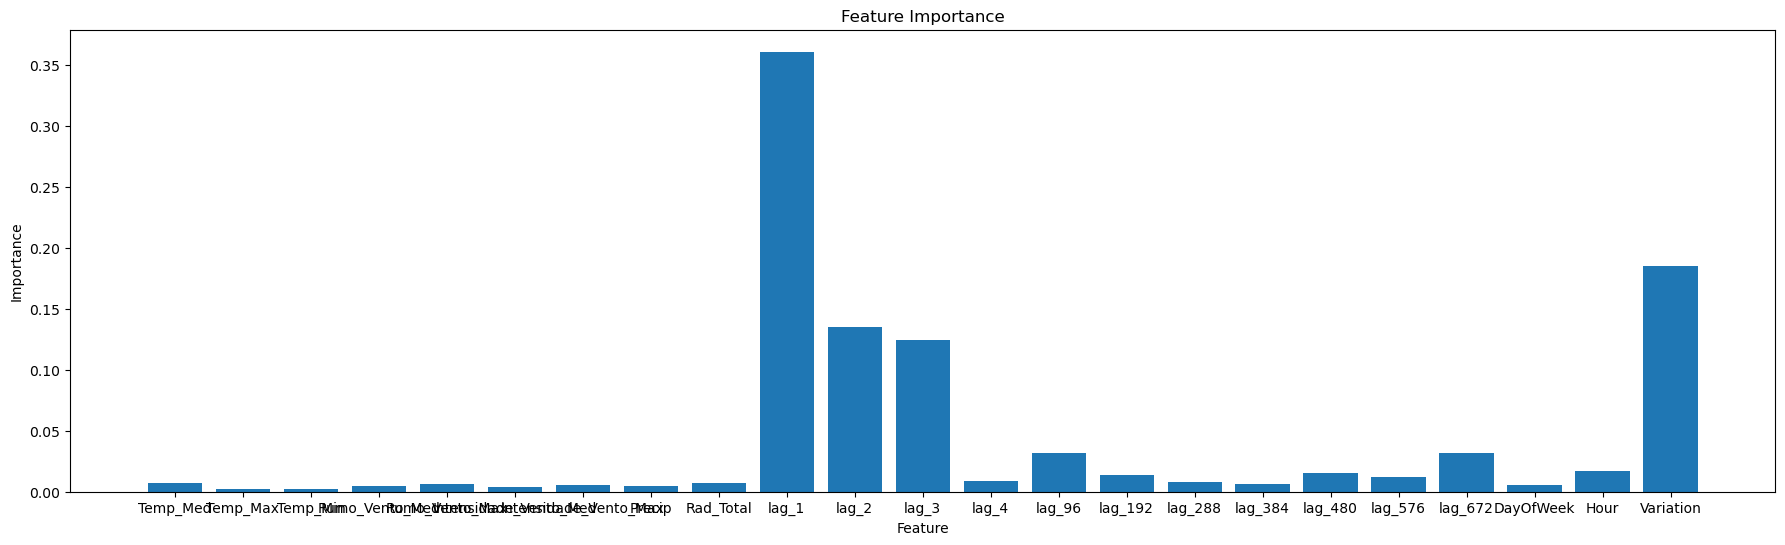

In [31]:
plt.figure(figsize=(22,6))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
#plt.savefig("../../images/loureiro_xgb_feature_importance.png")
plt.show()

In [45]:
df_5percent = df.drop(["Time", "Location", "Energy"],axis=1).columns[model_xgb.feature_importances_ > 0.05]
df_5percent = pd.concat([df[["Time","Location", "Energy"]],df[df_5percent]], axis=1)
df_5percent

,Time,Location,Energy,lag_1,lag_2,lag_3,Variation
0,2022-05-12 12:00:00,Energy_1,0.039,0.016,0.058,0.038,0.000000
1,2022-05-12 12:15:00,Energy_1,0.061,0.039,0.016,0.058,0.563702
2,2022-05-12 12:30:00,Energy_1,0.038,0.061,0.039,0.016,-0.377151
3,2022-05-12 12:45:00,Energy_1,0.069,0.038,0.061,0.039,0.815312
4,2022-05-12 13:00:00,Energy_1,0.063,0.069,0.038,0.061,-0.087089
...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,0.009,0.010,0.009,0.032,-0.100899
1413236,2023-06-07 01:30:00,Energy_96,0.009,0.009,0.010,0.009,-0.001110
1413237,2023-06-07 01:45:00,Energy_96,0.040,0.009,0.009,0.010,3.439512
1413238,2023-06-07 02:00:00,Energy_96,0.038,0.040,0.009,0.009,-0.050237


In [47]:
sourceFile = open("../../gpu_logs/_loureiro_variation_best.txt", "w")

In [48]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0031
RMSE: 0.0561
WAPE: 35.99
R2: 0.5829

Iteration 1
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0026
RMSE: 0.0516
WAPE: 40.72
R2: 0.7586

Iteration 2
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0069
RMSE: 0.0836
WAPE: 34.22
R2: 0.6792

Iteration 3
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0071
RMSE: 0.0843
WAPE: 37.71
R2: 0.6961

Iteration 4
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0025
RMSE: 0.0508
WAPE: 32.82
R2: 0.7706

Iteration 5
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0031
RMSE: 0.0563
WAPE: 36.70
R2: 0.6927

Iteration 6
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0043
RMSE: 0.0657
WAPE: 39.04
R2: 0.5560

Iteration 7
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0029
RMSE: 0.0538
WAPE: 37.25
R2:

In [49]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.1, max_depth=16, n_estimators=1000), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0003
RMSE: 0.0185
WAPE: 8.04
R2: 0.9543

Iteration 1
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0007
RMSE: 0.0282
WAPE: 12.12
R2: 0.9277

Iteration 2
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0010
RMSE: 0.0321
WAPE: 9.73
R2: 0.9526

Iteration 3
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0017
RMSE: 0.0413
WAPE: 12.18
R2: 0.9269

Iteration 4
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0003
RMSE: 0.0176
WAPE: 7.91
R2: 0.9724

Iteration 5
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0005
RMSE: 0.0225
WAPE: 10.30
R2: 0.9508

Iteration 6
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0004
RMSE: 0.0203
WAPE: 8.07
R2: 0.9574

Iteration 7
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)
MSE: 0.0002
RMSE: 0.0159
WAPE: 7.96
R2: 0.96

In [50]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0102
WAPE: 2.80
R2: 0.9859

Iteration 1
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0005
RMSE: 0.0225
WAPE: 5.04
R2: 0.9542

Iteration 2
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0004
RMSE: 0.0205
WAPE: 4.30
R2: 0.9806

Iteration 3
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0008
RMSE: 0.0298
WAPE: 5.56
R2: 0.9619

Iteration 4
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0000
RMSE: 0.0096
WAPE: 2.89
R2: 0.9917

Iteration 5
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0138
WAPE: 3.58
R2: 0.9815

Iteration 6
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0100
WAPE: 2.48
R2: 0.9895

Iteration 7
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0000
RMSE: 0.0091
WAPE: 2.77
R2: 0.9894

Iteration 8
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0106
WAPE: 3.50
R2: 0.9836

Iteration 9
split location
Train set:  (1130592, 26)
Test set:  (282648, 26)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0001
RMSE: 0.0126
WAPE: 3.28
R2: 0.9901


In [51]:
print("\n\n\n", file=sourceFile)
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)
sourceFile.close()

Total Averaged MSE: 0.004
Total Averaged WAPE: 37.164
Total Averaged R2: 0.668
Total Averaged MSE: 0.001
Total Averaged WAPE: 9.446
Total Averaged R2: 0.953
Total Averaged MSE: 0.0
Total Averaged WAPE: 3.62
Total Averaged R2: 0.981


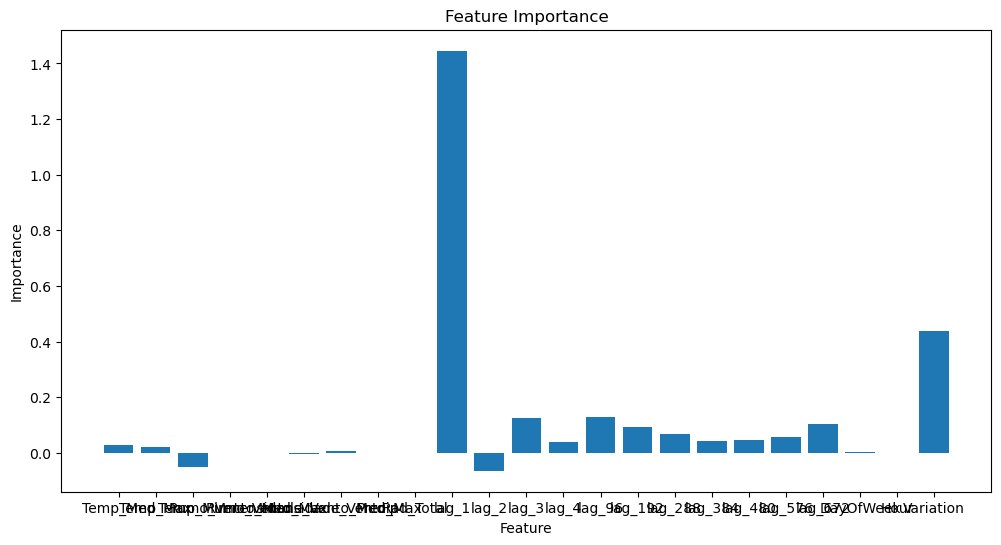

In [30]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

## Hyperparameter Tuning

In [ ]:
df_tuning = pd.read_csv("data/loureiro_selected.csv")
df_tuning.drop(['Time', 'Location'],axis=1, inplace=True)
df_tuning

In [ ]:
params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
params_xgb = { 
    'max_depth': [3, 6, 10, 20, 50],
    'learning_rate': [0.01, 0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
}

In [ ]:
train_features = df_tuning.drop('Energy', axis=1)
train_labels = df_tuning['Energy']
test_features = 0
test_labels = 0

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor(seed=42, tree_method="gpu_hist")

grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 5, n_jobs = 4, verbose = 2)

In [ ]:
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = cuRF(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

best_random = grid_search.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))